# 9 · Group‑Level RSA p‑values  
This notebook computes **two‑tailed permutation p‑values** for all ROI‑wise RSA effects used across the paper (intersubject, vision‑model, language‑model). Full raw permutation tensors (>2 TB) are reproducible via the extraction scripts; here we operate on **aggregated** summaries to obtain corrected p‑values and APA significance stars.


## Data overview  
Permutation tensors were pre‑compressed to reduce storage:  

| Original structure | Aggregation strategy | Final shape used here |
|--------------------|---------------------|-----------------------|
| Subject–Subject: `n_perm × n_pairs × n_rois × n_rois` | Mean over subject pairs; retain diagonal only | `n_perm × n_rois` |
| Subject–Model: `n_perm × n_models × n_subjects × n_sessions × n_layers × n_rois` | Signed‑max over layers per session → mean over models, subjects, sessions | `n_perm × n_rois` |



## Imports & file paths  
Load core libraries plus paths to: aggregated permutation arrays (subject, language, vision), observed RSA parquet files, and the HCP atlas for ROI metadata.


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_folder = Path("../derivatives")
filename_hcp = data_folder / "metadata" / "hcp.csv"
nsd_folder = data_folder / "nsd"

filename_agg_permutations_language = nsd_folder / "permutations_aggregated_language_amax.npy"
filename_agg_permutations_vision = nsd_folder / "permutations_aggregated_vision_amax.npy"
filename_agg_permutations_subject = nsd_folder / "permutations_subject_subject_rsa_joined_shift_1_agg_10000.npy"
filename_agg_observed_models = nsd_folder / "rsa_subject_model_alignment_joined.parquet"
filename_agg_observed_subject = nsd_folder / "rsa_subject_subject_alignment_shift_1_joined.parquet"

output_filename = nsd_folder / "rsa_pvalues_subject_language_vision.parquet"

## Helper functions  
`compute_stats` implements a **two‑tailed** permutation test:

$$
p = \frac{1}{N_{\text{perm}}+1}\sum_{i=1}^{N_{\text{perm}}} \mathbf{1}\{\,|x_i-\mu_{\text{null}}| \ge |x_{\text{obs}}-\mu_{\text{null}}|\,\}
$$

For each modality we record: observed RSA, null mean/SD, raw p, FDR‑BH corrected p, and APA star code.


In [3]:
def apa_significance(
    p, star_levels=(0.05, 0.01, 0.001, 0.0001), star_str=("*", "**", "***", "****")
):
    star_levels = np.array(star_levels)
    star_str = np.array(star_str)
    if p > 0.05:
        return "n.s."
    return star_str[p < star_levels][-1]


def compute_stats(data_observed, data_null, n_rois=180, n_permutations=10000, correction="fdr_bh"):

    # Check dimensions
    assert data_observed.shape[0] == data_null.shape[1] == n_rois
    assert data_null.shape[0] == n_permutations

    null_mean = data_null.mean(axis=0)  # => (n_rois, )
    normalized_null = np.abs(data_null - null_mean)  # => (n_permutations, n_rois)
    normalized_observed = np.abs(data_observed - null_mean)  # => (n_rois, )

    # Compute occurrences of null means greater than observed means
    occurrences = np.sum(normalized_null >= normalized_observed, axis=0)  # => (n_rois, )

    p_values = (occurrences + 1) / (data_null.shape[0] + 1)

    df_pvalues = pd.DataFrame(
        {
            "roi": np.arange(1, n_rois + 1),
            "pvalue": p_values,
            f"pvalue_{correction}": multipletests(p_values, method=correction)[1],
            "observed": data_observed,
            "null_mean": null_mean,
            "null_std": data_null.std(axis=0),
        }
    )
    df_pvalues["apa_star"] = df_pvalues[f"pvalue_{correction}"].apply(apa_significance)

    return df_pvalues


def plot_null_distribution(null, df_pvalues_subject, roi):
    fig, axes = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={"width_ratios": [2, 1]})
    ax1, ax2 = axes
    hcp = pd.read_csv(filename_hcp)
    roi_name = hcp.query(f"roi == {roi}").name.values[0]
    observed_value = df_pvalues_subject.query(f"roi == {roi}").observed.values[0]
    mean_null = null[:, roi - 1].mean()
    std_null = null[:, roi - 1].std()
    p_value = df_pvalues_subject.query(f"roi == {roi}").pvalue_fdr_bh.values[0]
    modality = df_pvalues_subject.query(f"roi == {roi}").comparison.values[0]
    n_perms = null.shape[0]
    sns.histplot(
        data=null[:, roi - 1],
        ax=ax1,
        kde=True,
        stat="density",
        color="C0",
        label=f"Null Distribution {n_perms} permutations",
    )
    ax1.axvline(
        observed_value,
        color="C1",
        linestyle="-",
        label=f"Observed Value: {observed_value:.3f} ({modality})",
        linewidth=2,
    )
    ax1.axvline(mean_null, color="C2", linestyle="--", label=f"Null Mean: {mean_null:.3f}")
    ax1.axvline(
        mean_null + std_null,
        color="C3",
        linestyle=":",
        label=f"Null Mean +- std: {mean_null:.3f} +- {std_null:.3f}",
    )
    ax1.axvline(mean_null - std_null, color="C3", linestyle=":")
    ax1.set_title(f"Null Distribution {modality} for ROI {roi_name} ($p_{{fdr}}$={p_value:.4f})")
    ax1.legend()
    sns.despine(ax=ax1)
    # Quick qq-plot using a normal distribution
    sorted_null = np.sort(null[:, roi - 1])
    sorted_normal = np.sort(np.random.normal(loc=mean_null, scale=std_null, size=n_perms))
    ax2.scatter(sorted_normal, sorted_null, color="C0")
    ax2.set_title(f"QQ-Plot for ROI {roi}")
    sns.despine(ax=ax2)
    return fig, axes

## Intersubject (Subject–Subject) p‑values  

Observed alignment: average shifted RSA across distinct subject pairs, diagonal only.  
Permutation null: aggregated `n_perm × n_rois` array.  
We apply the two‑tailed test and FDR correction across 180 ROIs.


In [4]:

# Group level subject observed values (n_rois)
df_observed = pd.read_parquet(filename_agg_observed_subject)
df_observed = df_observed.query("roi_x == roi_y and subject_i != subject_j")
df_observed = df_observed.rename(columns={"roi_x": "roi"})
df_observed = df_observed.groupby(["roi"]).similarity.mean().reset_index()
data_observed = df_observed.similarity.values 

# Read data of permutations (n_permutations, n_rois)
data_null = np.load(filename_agg_permutations_subject)
print(f"Null data shape: {data_null.shape}")  # Should be (n_permutations, n_rois)

# Make a two-tailed permutation test
df_pvalues_subject = compute_stats(data_observed, data_null)
df_pvalues_subject["comparison"] = "intersubject"
df_pvalues_subject

Null data shape: (10000, 180)


,roi,pvalue,pvalue_fdr_bh,observed,null_mean,null_std,apa_star,comparison
0,1,0.000100,0.000161,0.194511,9.465456e-06,0.003569,***,intersubject
1,2,0.000100,0.000161,0.210775,6.518135e-06,0.002293,***,intersubject
2,3,0.000100,0.000161,0.012278,-3.537752e-06,0.001275,***,intersubject
3,4,0.000100,0.000161,0.177940,9.280093e-07,0.003676,***,intersubject
4,5,0.000100,0.000161,0.125448,2.677682e-05,0.003430,***,intersubject
...,...,...,...,...,...,...,...,...
175,176,0.000100,0.000161,0.004292,-9.744754e-06,0.000687,***,intersubject
176,177,0.017198,0.021059,0.001881,-1.083623e-05,0.000804,*,intersubject
177,178,0.003000,0.003941,0.000320,3.755545e-07,0.000105,**,intersubject
178,179,0.016398,0.020357,0.001305,-5.608162e-06,0.000546,*,intersubject


Quick inspection of the null distribution.

The two-tailed test assumes a symmetric null distribution, in fact for all rois the distributions are normal.

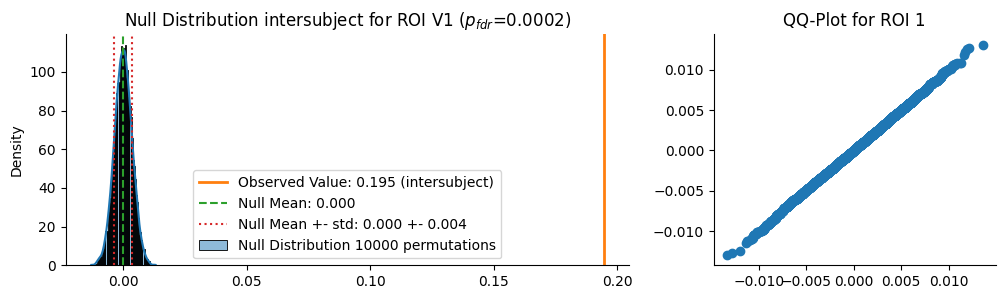

In [5]:
roi = 1
fig, axes = plot_null_distribution(data_null, df_pvalues_subject, roi)

# Uncomment to plot all ROIs
# for roi in range(1, 181): 
#     fig, axes = plot_null_distribution(data_null, df_pvalues_subject, roi)
#     plt.show()

## Subject–Model aggregation  

Observed RSA is reduced to one value per ROI × modality by:  
1. Taking the **signed** maximum (absolute value) across layers within each session/model/subject.  
2. Averaging across subjects, models (grouped into *vision* vs *language*), and sessions.  
This matches the permutation aggregation pipeline ensuring a valid null comparison.


In [6]:
# Aggregate the observed values at group level
df_observed = pd.read_parquet(filename_agg_observed_models)
df_observed["abs_similarity"] = df_observed.similarity.abs()
# Keep max (in abs terms) for each subject, roi, session, model (sort and keep first)
df_observed = df_observed.sort_values("abs_similarity", ascending=False)
df_observed = df_observed.drop_duplicates(
    subset=["subject", "roi", "session", "model"],
    keep="first",
)
df_observed = df_observed.groupby(["roi", "subject", "model"]).similarity.mean().reset_index()
df_observed = df_observed.groupby(["roi", "model"]).similarity.mean().reset_index()
df_observed["modality"] = df_observed["model"].apply(lambda x: "vision" if x.endswith("-cls") else "language")
df_observed = df_observed.groupby(["roi", "modality"]).similarity.mean().reset_index()
df_observed

,roi,modality,similarity
0,1,language,-0.001745
1,1,vision,0.165118
2,2,language,0.164321
3,2,vision,0.129602
4,3,language,0.016045
...,...,...,...
355,178,vision,0.004509
356,179,language,0.000871
357,179,vision,0.011757
358,180,language,0.001390


## Language‑model p‑values  
Compute two‑tailed permutation p‑values for the language modality using the pre‑aggregated null distribution. Add comparison label `"language"`.


In [7]:
# Language observed values (n_rois)
df_observed_language = df_observed.query("modality == 'language'").sort_values("roi")
data_observed = df_observed_language.similarity.values

# Language null
data_null = np.load(filename_agg_permutations_language)
print(f"Null data shape: {data_null.shape}")  # Should be (n_permutations, n_rois)
# Compute stats
df_pvalues_language = compute_stats(data_observed, data_null)
df_pvalues_language["comparison"] = "language"
df_pvalues_language

Null data shape: (10000, 180)


,roi,pvalue,pvalue_fdr_bh,observed,null_mean,null_std,apa_star,comparison
0,1,0.278872,0.351028,-0.001745,0.000711,0.002266,n.s.,language
1,2,0.000100,0.000225,0.164321,0.000365,0.001762,***,language
2,3,0.000100,0.000225,0.016045,0.000316,0.001603,***,language
3,4,0.000100,0.000225,-0.011911,0.000737,0.002296,***,language
4,5,0.000100,0.000225,-0.018913,0.000802,0.002311,***,language
...,...,...,...,...,...,...,...,...
175,176,0.000100,0.000225,0.016640,0.000219,0.001180,***,language
176,177,0.034197,0.053525,0.002840,0.000210,0.001244,n.s.,language
177,178,0.171783,0.227360,0.001015,0.000129,0.000641,n.s.,language
178,179,0.527947,0.590587,0.000871,0.000182,0.001098,n.s.,language


Inspect language null distribution.

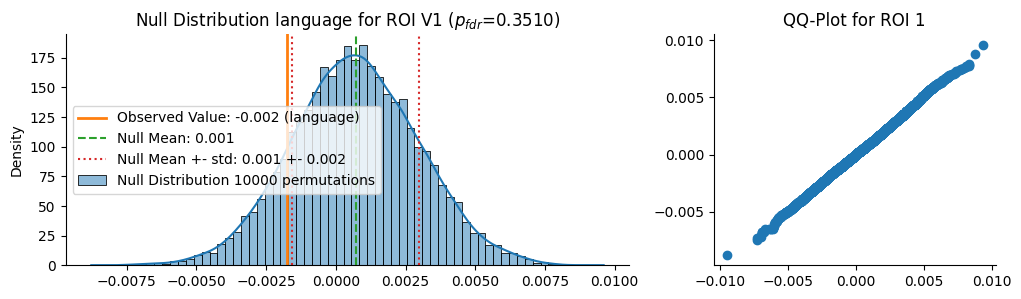

In [8]:
roi = 1
fig, axes = plot_null_distribution(data_null, df_pvalues_language, roi)

## Vision‑model p‑values  
Repeat the procedure for the vision models. Add comparison label `"vision"`.


In [9]:
# Vision observed values (n_rois)
df_observed_vision = df_observed.query("modality == 'vision'").sort_values("roi")
data_observed = df_observed_vision.similarity.values
# Vision null
data_null = np.load(filename_agg_permutations_vision)
# Compute stats
df_pvalues_vision = compute_stats(data_observed, data_null)
df_pvalues_vision["comparison"] = "vision"
df_pvalues_vision

,roi,pvalue,pvalue_fdr_bh,observed,null_mean,null_std,apa_star,comparison
0,1,0.0001,0.000103,0.165118,0.000916,0.002052,***,vision
1,2,0.0001,0.000103,0.129602,0.000470,0.001593,***,vision
2,3,0.0001,0.000103,0.051810,0.000408,0.001456,***,vision
3,4,0.0001,0.000103,0.166150,0.000968,0.002073,***,vision
4,5,0.0001,0.000103,0.139557,0.001055,0.002085,***,vision
...,...,...,...,...,...,...,...,...
175,176,0.0001,0.000103,0.024621,0.000251,0.001060,***,vision
176,177,0.0001,0.000103,0.011111,0.000239,0.001132,***,vision
177,178,0.0001,0.000103,0.004509,0.000144,0.000591,***,vision
178,179,0.0001,0.000103,0.011757,0.000221,0.001015,***,vision


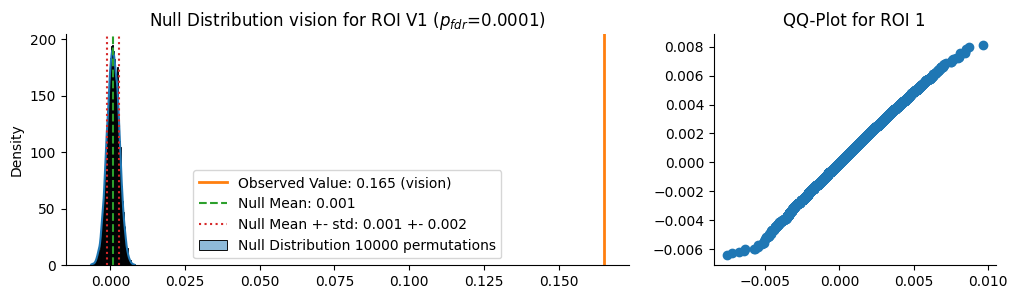

In [10]:
roi = 1
fig, axes = plot_null_distribution(data_null, df_pvalues_vision, roi)

## Save combined table  
Merge all three p‑value DataFrames, attach HCP ROI metadata, reorder columns, and write the unified parquet (if not already present). The resulting table underpins all subsequent significance reporting.


In [11]:
hcp = pd.read_csv(filename_hcp)
hcp = hcp[["roi", "name", "mne_name"]].query("roi <= 180")

df_pvalues = pd.concat([df_pvalues_subject, df_pvalues_language, df_pvalues_vision], axis=0, ignore_index=True)
df_pvalues = df_pvalues.merge(hcp, on="roi")

# Reorder columns 
columns = [
    "roi", "name", "comparison",
    "observed", "null_mean", "null_std", "pvalue", 
    "pvalue_fdr_bh", "apa_star", "mne_name",
]
df_pvalues = df_pvalues[columns] 
df_pvalues = df_pvalues.sort_values(["comparison", "roi"]).reset_index(drop=True)
if not output_filename.exists():
    df_pvalues.to_parquet(output_filename, index=False)

df_pvalues

,roi,name,comparison,observed,null_mean,null_std,pvalue,pvalue_fdr_bh,apa_star,mne_name
0,1,V1,intersubject,0.194511,9.465456e-06,0.003569,0.0001,0.000161,***,L_V1_ROI-lh
1,2,MST,intersubject,0.210775,6.518135e-06,0.002293,0.0001,0.000161,***,L_MST_ROI-lh
2,3,V6,intersubject,0.012278,-3.537752e-06,0.001275,0.0001,0.000161,***,L_V6_ROI-lh
3,4,V2,intersubject,0.177940,9.280093e-07,0.003676,0.0001,0.000161,***,L_V2_ROI-lh
4,5,V3,intersubject,0.125448,2.677682e-05,0.003430,0.0001,0.000161,***,L_V3_ROI-lh
...,...,...,...,...,...,...,...,...,...,...
535,176,STSva,vision,0.024621,2.512274e-04,0.001060,0.0001,0.000103,***,L_STSva_ROI-lh
536,177,TE1m,vision,0.011111,2.393079e-04,0.001132,0.0001,0.000103,***,L_TE1m_ROI-lh
537,178,PI,vision,0.004509,1.442655e-04,0.000591,0.0001,0.000103,***,L_PI_ROI-lh
538,179,a32pr,vision,0.011757,2.211569e-04,0.001015,0.0001,0.000103,***,L_a32pr_ROI-lh
